## 확장 프로젝트 2: 시기별(10년단위) Rates, Gross, Votes Top 10

### 전처리 및 데이터 특성

- **전처리 기준**: 연대(Decade)별 **영화 편수 ≥ 20편**인 연대만 분석에 포함  
- **데이터셋 특성**: *IMDB Top 1000*은 **최근 영화 중심**으로 구성되어 고전(1920~40년대) 영화 비중이 낮음  
  → 이로 인해 초기 연대는 Top 1000 기준에서 제외되거나 샘플 수가 부족해 분석 대상에서 탈락할 수 있음  

---



In [3]:
import os
import pandas as pd
import numpy as np
import kagglehub
# Download latest version
path = kagglehub.dataset_download("omarhanyy/imdb-top-1000")
file_path = os.path.join(path, "IMDB top 1000.csv")
print(file_path)
df = pd.read_csv(file_path)

# --- 기본 전처리 ---
df = df.dropna(subset=["Title", "Genre", "Rate"]).copy()
df["Rate"] = df["Rate"].astype(float)
df["Released_Year"] = df["Title"].str.extract(r"\((\d{4})\)").astype(int)

df["Info"] = df["Info"].fillna("Votes:0|Gross:$0M")

# Votes
df["Votes"] = (
    df["Info"].str.split("|").str[0]
      .str.replace("Votes:", "", regex=False)
      .str.replace(",", "", regex=False)
      .str.strip()
      .astype(float)
)

# Gross (M 단위 → 숫자)
df["Gross"] = (
    df["Info"].str.split("|").str[1]
      .str.replace("Gross:", "", regex=False)
      .str.replace("$", "", regex=False)
      .str.replace("M", "", regex=False)
      .str.strip()
)
df["Gross"] = pd.to_numeric(df["Gross"], errors="coerce").fillna(0.0)

# Decade & 중복 제거
df["Decade"] = (df["Released_Year"] // 10) * 10
df = df.drop_duplicates(subset="Title")

# 유효 연대 필터 (20편 이상 존재)
valid_decades = df["Decade"].value_counts().loc[lambda x: x >= 20].index
df_filtered = df[df["Decade"].isin(valid_decades)].copy()

# ---------- 핵심: 경고 없이 연대별 Top N 뽑기 ----------
def top_n_by(df_, col, n=10):
    # 연대별 정렬 후 각 연대에서 상위 n개 추출
    out = (
        df_.sort_values(["Decade", col], ascending=[True, False])
           .groupby("Decade", group_keys=True)
           .head(n)
           .copy()
    )
    # 보기 좋게 연대 내 순위 컬럼 추가
    out["Rank"] = (
        out.groupby("Decade")[col]
           .rank(method="first", ascending=False)
           .astype(int)
    )
    # "1930s" 형태 레이블도 같이 만들어두기(표시용)
    out["Decade_s"] = out["Decade"].astype(int).astype(str) + "s"
    return out.sort_values(["Decade", "Rank"])

top10_gross = top_n_by(df_filtered, "Gross", n=10)[["Decade_s", "Rank", "Title", "Released_Year", "Genre", "Gross"]]
top10_rate  = top_n_by(df_filtered, "Rate",  n=10)[["Decade_s", "Rank", "Title", "Released_Year", "Genre", "Rate"]]
top10_votes = top_n_by(df_filtered, "Votes", n=10)[["Decade_s", "Rank", "Title", "Released_Year", "Genre", "Votes"]]

/kaggle/input/imdb-top-1000/IMDB top 1000.csv


### 결과물 개요

- **목표**: 연대(10년 단위)별로 **Rate, Gross, Votes** 각각의 **Top 10 영화**를 추출  

- **산출물**:  
  1) **엑셀 파일**: `top10_by_metric.xlsx`  
     - 시트 3개 (`Gross`, `Rate`, `Votes`)에 지표별 Top10 영화 정보 저장  
  2) **그래프 이미지**: 연대별 Top10 영화 가로 막대 그래프 (PNG 형식)  
     - 저장 경로 예시 (Colab 기준):  
       - `/content/top10_imgs/gross/`  
       - `/content/top10_imgs/rate/`  
       - `/content/top10_imgs/votes/`  
     - 파일명 형식: `{Metric}_{Decade_s}.png`  
       - 예시: `Gross_1990s.png`, `Rate_2000s.png`, `Votes_2010s.png`  


### 엑셀 파일 상세 설명 (`top10_by_metric.xlsx`)

#### 공통 컬럼
- **Decade_s**: 연대 (예: `1980s`)  
- **Rank**: 해당 연대 내 순위 (1–10)  
- **Title**: 영화 제목  
- **Released_Year**: 개봉 연도  
- **Genre**: 장르  

#### 시트별 설명

##### 1) `Gross`
- **기준**: 흥행 수입 (**Gross**, 단위: **Million USD**)  
- **내용**: 연대별 흥행 수입 **Top 10** 영화  
- **특이사항**: `Gross` 컬럼 값은 **백만 달러** 단위  

##### 2) `Rate`
- **기준**: IMDb **평점(Rate)**  
- **내용**: 연대별 평점 **Top 10** 영화  
- **특이사항**: `Rate`는 **0–10 스케일** 평균 사용자 평점  

##### 3) `Votes`
- **기준**: IMDb **투표 수(Votes)**  
- **내용**: 연대별 투표 참여자 수 **Top 10** 영화  
- **특이사항**: `Votes`는 **원본 개수**(정수)이며, 필요 시 시각화/보고용으로 **백만 단위(M)** 변환 가능  

---

##### 해석 시 유의점
- **연대 필터(≥20편)** 로 인해 1950s 이후 연대가 주로 남을 수 있음 (초기 연대 데이터 희소성)  
- **지표별 Top10** 은 **동일 연대 내 상대 순위** 이므로, 서로 다른 연대 간 절대 비교 시 **샘플 수와 시대 효과**를 함께 고려할 것  

- 준비: 단위/표시 포맷 헬퍼

In [4]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.3 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def _fmt_unit(value, metric):
    if metric == "Gross":   # 이미 M 단위
        return f"{value:.1f}M"
    if metric == "Votes":   # 표시는 백만 단위로
        return f"{value/1_000_000:.2f}M"
    if metric == "Rate":
        return f"{value:.1f}"
    return str(value)

- 테이블링

In [6]:
def style_top10_table(df_top, metric):
    fmt_dict = {
        "Gross": lambda v: f"{v:.1f}M",
        "Votes": lambda v: f"{v:,.0f}",
        "Rate":  lambda v: f"{v:.1f}",
    }
    fmter = fmt_dict.get(metric, str)

    cols = ["Decade_s", "Rank", "Title", "Released_Year", "Genre", metric]
    styled = (
        df_top[cols]
          .style
          .hide(axis="index")
          .set_table_attributes('style="border-collapse:collapse"')
          .set_properties(**{"border":"1px solid #ddd", "padding":"6px"})
          .format({metric: fmter})
          .set_caption(f"Top 10 by {metric} per Decade")
    )
    return styled
# === 데이터 확인 ===
display(style_top10_table(top10_gross, "Gross"))
display(style_top10_table(top10_rate, "Rate"))
display(style_top10_table(top10_votes, "Votes"))

# === Excel 저장 ===
with pd.ExcelWriter("top10_by_metric.xlsx", engine="xlsxwriter") as writer:
    # Gross Top10 저장
    top10_gross.to_excel(writer, sheet_name="Gross", index=False)
    # Rate Top10 저장
    top10_rate.to_excel(writer, sheet_name="Rate", index=False)
    # Votes Top10 저장
    top10_votes.to_excel(writer, sheet_name="Votes", index=False)

print("✅ top10_by_metric.xlsx 파일이 저장되었습니다.")


Decade_s,Rank,Title,Released_Year,Genre,Gross
1950s,1,298. Ben-Hur (1959),1959,"Adventure, Drama, History",74.7M
1950s,2,303. The Bridge on the River Kwai (1957),1957,"Adventure, Drama, War",44.9M
1950s,3,80. Rear Window (1954),1954,"Mystery, Thriller",36.8M
1950s,4,180. Some Like It Hot (1959),1959,"Comedy, Music, Romance",25.0M
1950s,5,119. North by Northwest (1959),1959,"Adventure, Mystery, Thriller",13.3M
1950s,6,304. On the Waterfront (1954),1954,"Crime, Drama, Thriller",9.6M
1950s,7,121. Singin' in the Rain (1952),1952,"Comedy, Musical, Romance",8.8M
1950s,8,78. Witness for the Prosecution (1957),1957,"Crime, Drama, Mystery",8.2M
1950s,9,8. 12 Angry Men (1957),1957,"Crime, Drama",4.4M
1950s,10,306. Ace in the Hole (1951),1951,"Drama, Film-Noir",4.0M


Decade_s,Rank,Title,Released_Year,Genre,Rate
1950s,1,8. 12 Angry Men (1957),1957,"Crime, Drama",8.9
1950s,2,31. Seven Samurai (1954),1954,"Action, Adventure, Drama",8.6
1950s,3,78. Witness for the Prosecution (1957),1957,"Crime, Drama, Mystery",8.4
1950s,4,79. Paths of Glory (1957),1957,"Drama, War",8.4
1950s,5,80. Rear Window (1954),1954,"Mystery, Thriller",8.4
1950s,6,81. Sunset Blvd. (1950),1950,"Drama, Film-Noir",8.4
1950s,7,119. North by Northwest (1959),1959,"Adventure, Mystery, Thriller",8.3
1950s,8,120. Vertigo (1958),1958,"Mystery, Romance, Thriller",8.3
1950s,9,121. Singin' in the Rain (1952),1952,"Comedy, Musical, Romance",8.3
1950s,10,122. Ikiru (1952),1952,Drama,8.3


Decade_s,Rank,Title,Released_Year,Genre,Votes
1950s,1,8. 12 Angry Men (1957),1957,"Crime, Drama","674,629"
1950s,2,80. Rear Window (1954),1954,"Mystery, Thriller","435,967"
1950s,3,120. Vertigo (1958),1958,"Mystery, Romance, Thriller","356,579"
1950s,4,31. Seven Samurai (1954),1954,"Action, Adventure, Drama","310,435"
1950s,5,119. North by Northwest (1959),1959,"Adventure, Mystery, Thriller","294,175"
1950s,6,180. Some Like It Hot (1959),1959,"Comedy, Music, Romance","239,812"
1950s,7,298. Ben-Hur (1959),1959,"Adventure, Drama, History","216,130"
1950s,8,121. Singin' in the Rain (1952),1952,"Comedy, Musical, Romance","214,849"
1950s,9,303. The Bridge on the River Kwai (1957),1957,"Adventure, Drama, War","200,215"
1950s,10,81. Sunset Blvd. (1950),1950,"Drama, Film-Noir","197,786"


✅ top10_by_metric.xlsx 파일이 저장되었습니다.


### 그래프 이미지 상세 설명

#### 공통 요소
- **Decade_s**: 연대 (예: `1980s`)  
- **Metric**: 기준 지표 (`Gross`, `Rate`, `Votes`)  
- **Title**: 영화 제목 (Y축 라벨)  
- **Value**: 선택한 지표 값 (X축)  
- **파일명 규칙**: `{Metric}_{Decade_s}.png`  
  - 예시: `Gross_1990s.png`, `Rate_2000s.png`, `Votes_2010s.png`  

---

#### 지표별 설명

##### 1) Gross
- **기준**: 흥행 수입 (**Gross**, 단위: Million USD)  
- **내용**: 연대별 흥행 수입 Top 10 영화 → 가로 막대 그래프  
- **특이사항**: X축 단위는 **백만 달러(Million USD)**  

##### 2) Rate
- **기준**: IMDb **평점(Rate)**  
- **내용**: 연대별 평점 Top 10 영화 → 가로 막대 그래프  
- **특이사항**: X축 값은 **0–10 스케일 평균 사용자 평점**  

##### 3) Votes
- **기준**: IMDb **투표 수(Votes)**  
- **내용**: 연대별 투표 참여자 수 Top 10 영화 → 가로 막대 그래프  
- **특이사항**: 그래프에서는 **백만 단위(M)** 로 변환하여 표시  

---

#### 저장 구조
- **저장 경로**:  
  - `/content/top10_imgs/gross/`  
  - `/content/top10_imgs/rate/`  
  - `/content/top10_imgs/votes/`  
- **각 폴더별** 연대(10년 단위) Top10 영화 이미지 저장  
- **예시**:  
  - `Gross_1990s.png`  
  - `Rate_2000s.png`  
  - `Votes_2010s.png`  

---

#### 해석 시 유의점
- **연대 필터(≥20편)** 적용으로 인해, 주로 **1950s 이후 연대**의 이미지가 생성됨 (초기 연대 데이터 부족)  
- 각 이미지는 **동일 연대 내 Top10 순위 비교**에 적합  
- 서로 다른 연대의 이미지를 직접 비교할 경우, **샘플 수와 시대적 특성 차이**를 반드시 고려해야 함  


In [7]:
# === Top10 H-Bar 시각화/저장: 정리 버전 ===
import os
import numpy as np
import matplotlib.pyplot as plt

# 공통: 축 라벨 텍스트 생성
_METRIC_XLABEL = {
    "Gross": "Gross (Million USD)",
    "Votes": "Votes (Millions)",
    "Rate":  "Rating",
}

# 공통: 값 포맷
def _value_label(val_raw, metric):
    if metric == "Votes":
        return f"{val_raw/1_000_000:.2f}M"
    if metric == "Gross":
        return f"{val_raw:.1f}M"
    return f"{val_raw:.1f}"  # Rate

# 공통: x축 값 변환(표시 단위에 맞춰)
def _x_values(values, metric):
    if metric == "Votes":
        return values / 1_000_000  # 백만 단위로
    return values  # Gross는 M 단위, Rate는 원 단위

def plot_top10_hbar(
    df_top,
    metric: str,
    decade_s: str | None = None,
    figsize=(10, 6),
    annotate: bool = True,
    color=None,
    title_prefix: str = "Top 10 by"
):
    """
    df_top: top10_* DataFrame (예: top10_gross)
    metric: "Gross" | "Rate" | "Votes"
    decade_s: "1980s" 처럼 특정 연대만 그릴 때 지정. None이면 첫 연대 사용.
    """
    assert metric in {"Gross", "Rate", "Votes"}, "metric must be one of {'Gross','Rate','Votes'}"

    data = df_top.copy()
    if decade_s is None:
        decade_s = data["Decade_s"].iloc[0]
    data = data[data["Decade_s"] == decade_s].copy()

    # 큰 값이 위로 오도록: 값 오름차순 정렬 후 y축 뒤집기
    data = data.sort_values(metric, ascending=True)
    titles = data["Title"].values
    vals   = data[metric].values
    x      = _x_values(vals, metric)

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(titles, x, color=color)
    ax.set_title(f"{decade_s} — {title_prefix} {metric}", fontsize=14)
    ax.set_xlabel(_METRIC_XLABEL[metric], fontsize=12)
    ax.set_ylabel("Title")
    ax.grid(True, axis="x")
    ax.invert_yaxis()  # 가장 큰 값이 위로 가도록

    if annotate:
        # 바 끝에 값 라벨
        for i, v in enumerate(x):
            ax.text(v, i, f"  {_value_label(vals[i], metric)}", va="center")

    plt.tight_layout()
    plt.show()


def export_all_decades(
    df_top,
    metric: str,
    out_dir: str = "export_top10",
    figsize=(10, 6),
    dpi: int = 200,
    color=None,
    annotate: bool = True,
    title_prefix: str = "Top 10 by"
):
    """
    연대별 Top10 영화 막대 그래프를 PNG로 모두 저장
    """
    assert metric in {"Gross", "Rate", "Votes"}, "metric must be one of {'Gross','Rate','Votes'}"
    os.makedirs(out_dir, exist_ok=True)

    decades = list(df_top["Decade_s"].unique())
    for d in decades:
        data = df_top[df_top["Decade_s"] == d].copy().sort_values(metric, ascending=True)
        titles = data["Title"].values
        vals   = data[metric].values
        x      = _x_values(vals, metric)

        fig, ax = plt.subplots(figsize=figsize)
        ax.barh(titles, x, color=color)
        ax.set_title(f"{d} — {title_prefix} {metric}", fontsize=14)
        ax.set_xlabel(_METRIC_XLABEL[metric], fontsize=12)
        ax.set_ylabel("Title")
        ax.grid(True, axis="x")
        ax.invert_yaxis()

        if annotate:
            for i, v in enumerate(x):
                ax.text(v, i, f"  {_value_label(vals[i], metric)}", va="center")

        plt.tight_layout()
        fname = f"{metric}_{d}.png".replace(" ", "_")
        fig.savefig(os.path.join(out_dir, fname), dpi=dpi)
        plt.close(fig)

    print(f"✅ 저장 완료: {metric} 그래프 {len(decades)}개 → {out_dir}")

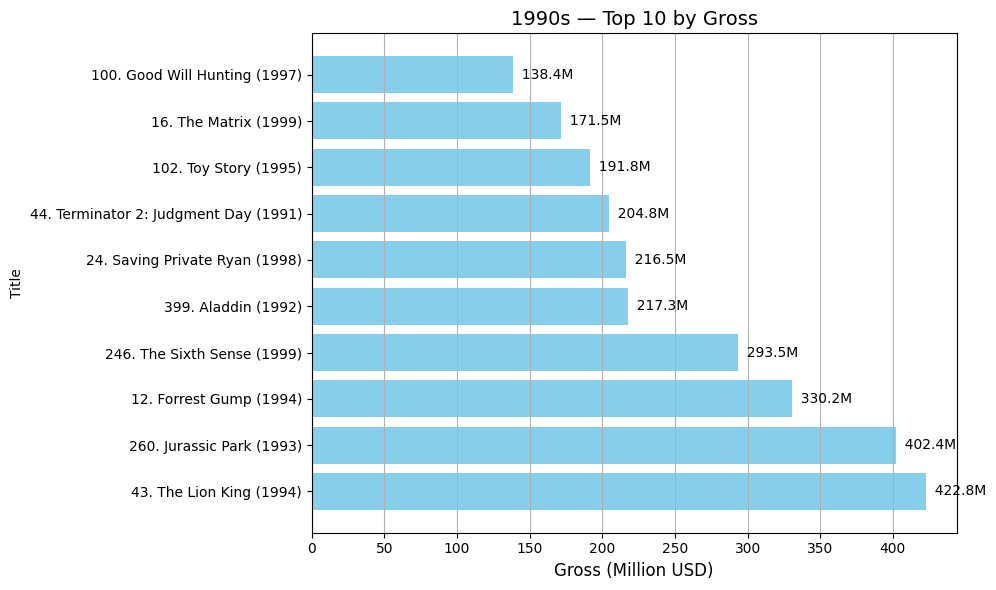

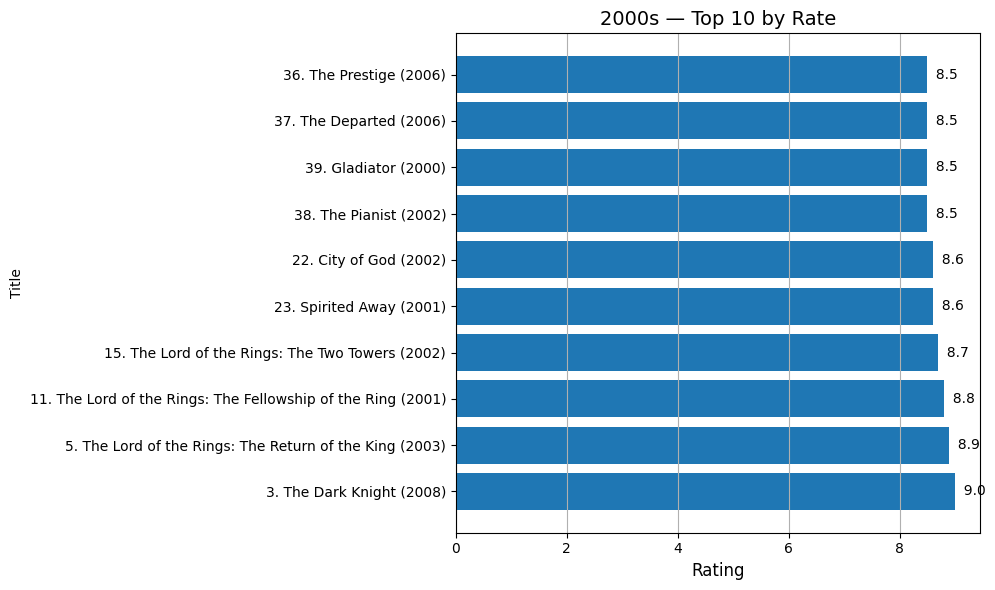

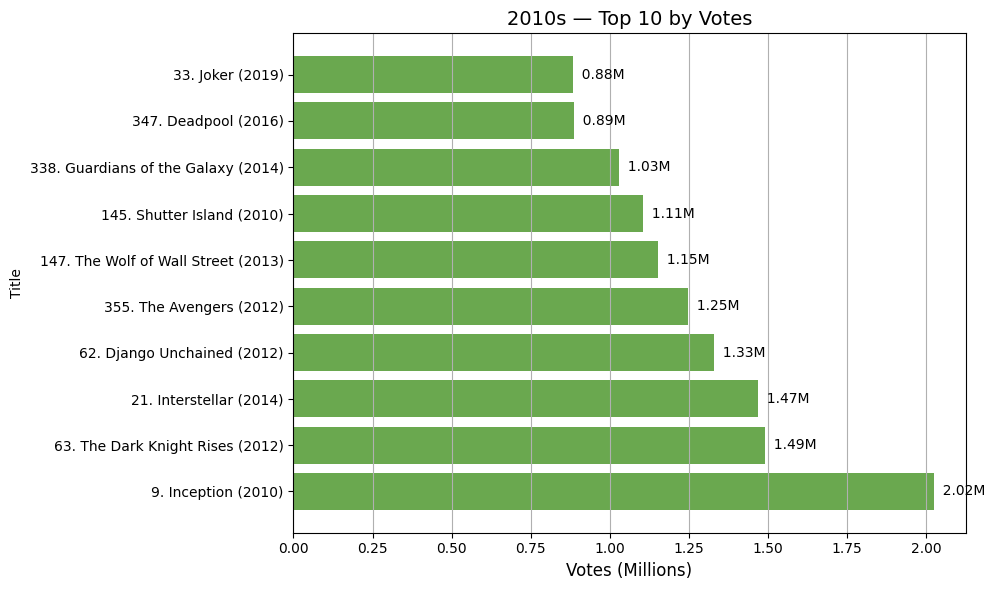

✅ 저장 완료: Gross 그래프 7개 → top10_imgs/gross
✅ 저장 완료: Rate 그래프 7개 → top10_imgs/rate
✅ 저장 완료: Votes 그래프 7개 → top10_imgs/votes


In [8]:
# 단일 연대 그리기 ( 저장 이미지 예시 확인 )
plot_top10_hbar(top10_gross, "Gross", decade_s="1990s", color="skyblue")
plot_top10_hbar(top10_rate,  "Rate",  decade_s="2000s")
plot_top10_hbar(top10_votes, "Votes", decade_s="2010s", color="#6aa84f")

# 연대별 PNG 일괄 저장
export_all_decades(top10_gross, "Gross", out_dir="top10_imgs/gross", color="skyblue")
export_all_decades(top10_rate,  "Rate",  out_dir="top10_imgs/rate")
export_all_decades(top10_votes, "Votes", out_dir="top10_imgs/votes", color="#6aa84f")